In [1]:
from kan import *
import pytz
import time
import datetime
from data_process import data_process_without_norm
from sklearn.preprocessing import StandardScaler,MinMaxScaler

df = data_process_without_norm()
df = df.drop("entsoe",axis=1)
loc_tz = pytz.timezone('Europe/Zurich')
split_date_train_ = loc_tz.localize(datetime.datetime(2016,7,1,0,0,0,0))
split_date_train = loc_tz.localize(datetime.datetime(2016,9,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2016,9,15,0,0,0,0))

df_train_ = df.loc[(split_date_train_ < df.index)]
df_train = df_train_.loc[df_train_.index <= split_date_train].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# 输入标准化
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#输出标准化
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#测试集标准化
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))


_temp_train_input = np.hstack((x_train_input[:,:8],x_train_input[:,-3:-1]))
_temp_train_label = x_train_label

_temp_test_input = np.hstack((x_test_input[:,:8],x_test_input[:,-3:-1]))
_temp_test_label = x_test_label


_temp_train_input_for_NN = x_train_input

_temp_test_input_for_NN = x_test_input


dataset = dict()
dataset_ = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset_['train_input_for_NN'] = torch.tensor(_temp_train_input_for_NN.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset_['test_input_for_NN'] = torch.tensor(_temp_test_input_for_NN.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

# dataset['test_input'] = torch.tensor(np.array(X_test)[:,:32])
# dataset['test_label'] = torch.tensor(np.array(y_test))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



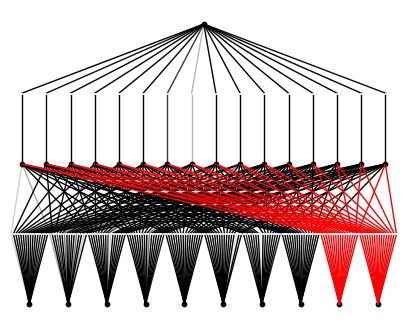

In [2]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[10,16,1], grid=10, k=3, seed=0, device=device)# create dataset f(x,y) = exp(sin(pi*x)+y^2)

model(dataset['train_input']);

for i in range(16):
    model.fix_symbolic(0,9,i,'sin',fit_params_bool=False)
    model.fix_symbolic(0,8,i,'sin',fit_params_bool=False)

# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100);

In [3]:
# train the model
start_time = time.time()
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01, lamb_entropy=10.);
end_time = time.time()
print(end_time - start_time)

train loss: 4.52e-01 | test loss: 5.78e-01 | reg: 7.33e+01 : 100%|██| 50/50 [00:52<00:00,  1.05s/it]

52.66887331008911


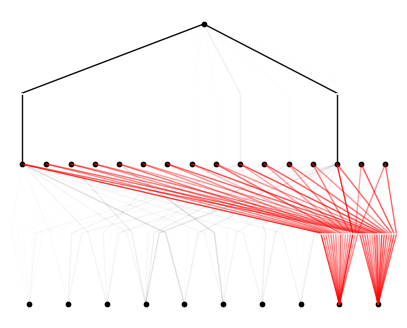

In [4]:
model.plot()

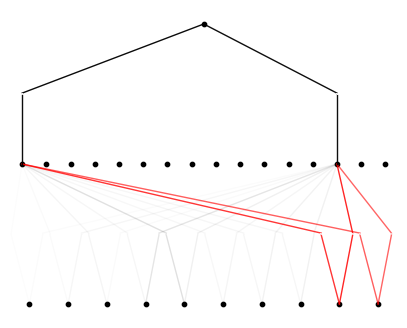

In [5]:
model.prune(threshold=5e-2)
model.plot(mask=True)

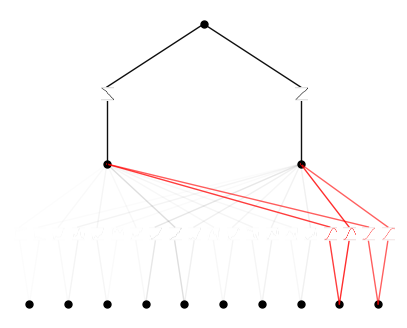

In [6]:
model = model.prune(5e-2)
model(dataset['train_input'])
model.plot()

In [7]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 4.65e-01 | test loss: 5.75e-01 | reg: 9.61e+00 : 100%|██| 50/50 [00:12<00:00,  3.97it/s]


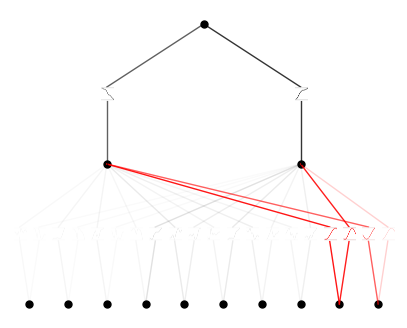

In [8]:
model.plot()

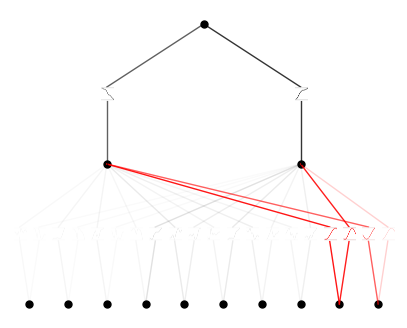

In [9]:
model.prune(threshold=5e-2)
model.plot(mask=True)

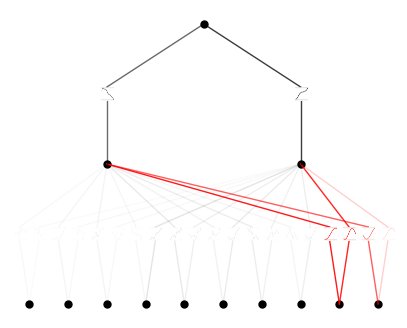

In [10]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [11]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 4.68e-01 | test loss: 5.57e-01 | reg: 8.76e+00 : 100%|██| 50/50 [00:12<00:00,  3.94it/s]


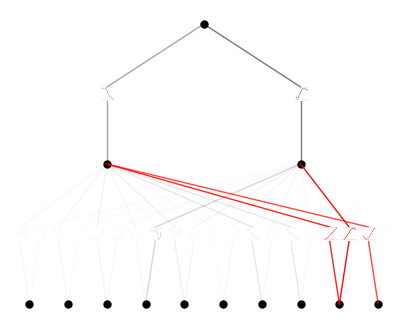

In [12]:
model.plot()

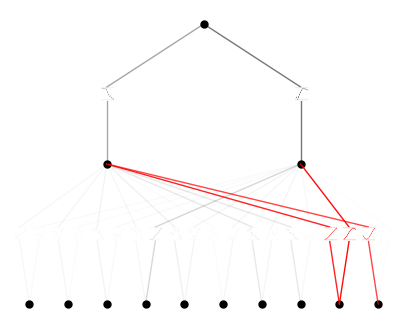

In [13]:
model.prune(threshold=5e-2)
model.plot(mask=True)

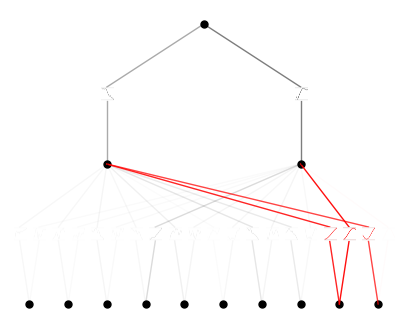

In [14]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [15]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 4.74e-01 | test loss: 5.39e-01 | reg: 8.55e+00 : 100%|██| 50/50 [00:12<00:00,  4.15it/s]


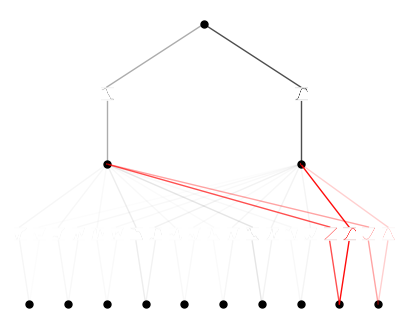

In [16]:
model.plot()

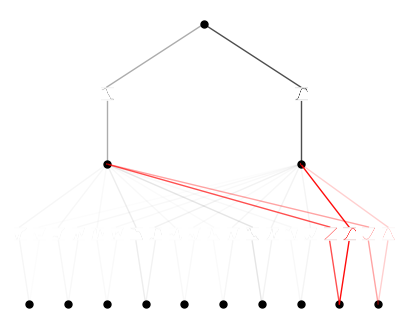

In [17]:
model.prune(threshold=5e-2)
model.plot(mask=True)

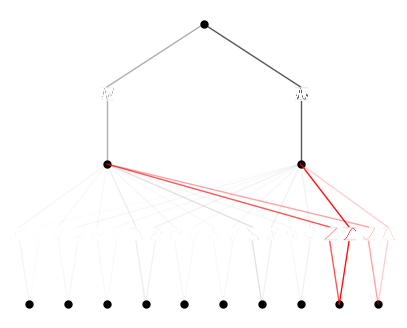

In [18]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [19]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 4.70e-01 | test loss: 4.76e-01 | reg: 9.04e+00 : 100%|██| 50/50 [00:12<00:00,  3.96it/s]


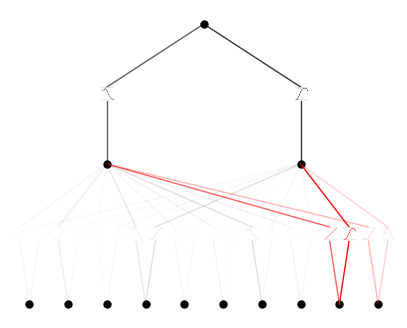

In [20]:
model.plot()

In [21]:
inter_units = 2
func_0 = []
for i in range(10):
    for j in range(inter_units):
        func_0.append(model.suggest_symbolic(0,i,j)[0])

func_1 = []
for i in range(inter_units):
    for j in range(1):
        func_1.append(model.suggest_symbolic(1,i,j)[0])

for i,j in enumerate(func_0):
    if j in ['abs','sgn']:
        func_0[i] = 'x^2'

for i,j in enumerate(func_0):
    if j in ['abs','sgn']:
        func_0[i] = 'x^2'

for i in range(10):
    for j in range(inter_units):
        model.fix_symbolic(0,i,j,func_0[i*inter_units+j],fit_params_bool=True)
for i in range(inter_units):
    for j in range(1):
        model.fix_symbolic(0,i,j,func_1[i*1+j],fit_params_bool=True)

function , r2
sigmoid , 0.8834294080734253
tanh , 0.8834181427955627
sin , 0.8827634453773499
gaussian , 0.882507860660553
arctan , 0.8812854290008545
function , r2
tan , 0.9642614722251892
1/x , 0.9637416005134583
arctan , 0.9637170433998108
1/sqrt(x) , 0.9636178612709045
1/x^2 , 0.9636174440383911
function , r2
tanh , 0.994886577129364
sigmoid , 0.9948840737342834
gaussian , 0.9945268034934998
arctan , 0.9917954206466675
x^2 , 0.9875199198722839
function , r2
sin , 0.7066624164581299
gaussian , 0.28732189536094666
tanh , 0.22379650175571442
sgn , 0.21741622686386108
sigmoid , 0.19148387014865875
function , r2
abs , 0.8758725523948669
gaussian , 0.8338470458984375
sin , 0.8324887156486511
x^2 , 0.8232895135879517
cosh , 0.8208576440811157
function , r2
sin , 0.7603583335876465
gaussian , 0.5506422519683838
abs , 0.2921339273452759
sgn , 0.23141127824783325
tanh , 0.23009070754051208
function , r2
tanh , 0.999110996723175
sigmoid , 0.9991083741188049
gaussian , 0.9989905953407288
arcta

In [22]:
model.train(dataset, opt="LBFGS", lr=0.01, steps=50, batch=128, lamb=0.01);

train loss: 5.71e-01 | test loss: 4.69e-01 | reg: 8.84e+00 : 100%|██| 50/50 [00:12<00:00,  3.88it/s]


In [23]:
model.symbolic_formula()[0]

[-143.15*cosh(-0.05*sin(0.97*x_10 + 2.01) + 0.22*sin(0.21*x_9 - 6.37) + 0.01*tan(0.41*x_6 + 6.32) - 0.e-2*tanh(0.99*x_4 - 0.94) + 0.14 + 0.04*exp(-0.73*(-0.87*x_7 - 1)**2) - 0.01*exp(-0.51*(-x_1 - 0.76)**2) + 0.03*exp(-2.77*(1 - 0.6*x_2)**2) + 0.01*exp(-2.0*(0.63 - x_5)**2)) - 17.37*cosh(0.04*sin(1.8*x_10 + 5.24) - 0.e-2*sin(5.85*x_2 - 0.98) + 0.01*sin(3.11*x_3 + 4.4) + 0.04*sin(1.14*x_4 - 9.58) - 0.e-2*sin(3.15*x_6 - 3.41) - 0.e-2*sin(3.39*x_8 + 7.79) + 0.25*sin(1.34*x_9 - 2.75) + 0.02*tan(0.28*x_1 - 2.6) + 0.2 - 0.02*exp(-1.73*(-x_7 - 0.48)**2)) + 162.14]

In [24]:
from xgboost import XGBRegressor as XGBR
start_time = time.time()
XGBR_reg = XGBR(n_estimators=100).fit(dataset['train_input'].detach().numpy(), dataset['train_label'].detach().numpy())
XGBR_pre = XGBR_reg.predict(dataset['test_input'].detach().numpy())
end_time = time.time()
print(end_time - start_time)

0.11089396476745605


In [25]:
loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(dataset['train_input'], dataset['train_label']), batch_size=128, shuffle=True)

num_inputs, num_outputs= 10, 1
net_1 = nn.Sequential()
net_1.add_module('linear1',nn.Linear(num_inputs,16))
net_1.add_module('sigmoid',nn.Sigmoid())
net_1.add_module('linear2',nn.Linear(16,1))

net_2 = nn.Sequential()
net_2.add_module('linear1',nn.Linear(num_inputs,2))
net_2.add_module('sigmoid',nn.Sigmoid())
net_2.add_module('linear2',nn.Linear(2,1))

In [26]:
def RMSE(_pre,_actual):
    MSE = ((_pre-_actual)**2)/15/24   
    return np.sqrt(MSE.sum())
    
def MAE(_pre,_actual):
    return (np.abs((_pre-_actual))).sum()/15/24
    
def MAPE(_pre,_actual):
    return ((np.abs((_pre-_actual)))/_actual).sum()/15/24
    
def evaluation(_pre,_actual): 
    return [RMSE(_pre,_actual),MAE(_pre,_actual),MAPE(_pre,_actual)]
    

In [27]:
loss_func_1 = torch.nn.MSELoss()
optimizer_1 = torch.optim.Adam(net_1.parameters(), lr = 0.01)
loss_func_2 = torch.nn.MSELoss()
optimizer_2 = torch.optim.Adam(net_2.parameters(), lr = 0.01)

start_time = time.time()
for epoch in range(50):
    for step, (x,y) in enumerate(loader):          # for each training step
        output = net_1(x)                           # get output for every net
        loss_1 = loss_func_1(output, y)                # compute loss for every net
        optimizer_1.zero_grad()                             # clear gradients for next train
        loss_1.backward()                             # backpropagation, compute gradients
        optimizer_1.step()                                  # apply gradients
end_time = time.time()
print(end_time - start_time)

start_time = time.time()
for epoch in range(50):
    for step, (x,y) in enumerate(loader):          # for each training step
        output = net_2(x)                           # get output for every net
        loss_2 = loss_func_2(output, y)                # compute loss for every net
        optimizer_2.zero_grad()                             # clear gradients for next train
        loss_2.backward()                             # backpropagation, compute gradients
        optimizer_2.step()                                  # apply gradients
end_time = time.time()
print(end_time - start_time)

0.7313275337219238
0.6678202152252197


In [28]:
pre_ann_1 = net_1.forward(dataset['test_input']).detach().numpy()
pre_ann_2 = net_2.forward(dataset['test_input']).detach().numpy()
pre_KAN = model.forward(dataset['test_input']).detach().numpy()

actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))
pre_ann_1_ = scaler_output.inverse_transform(pre_ann_1)
pre_ann_2_ = scaler_output.inverse_transform(pre_ann_2)
pre_KAN_ = scaler_output.inverse_transform(pre_KAN)
XGBR_pre_ = scaler_output.inverse_transform(XGBR_pre.reshape(-1,1))

result = dict()
result["ann_1"] = evaluation(pre_ann_1_,actual)
result["ann_2"] = evaluation(pre_ann_2_,actual)
result["KAN"] = evaluation(pre_KAN_,actual)
result["XGBR"] = evaluation(XGBR_pre_,actual)

In [29]:
result

{'ann_1': [333.15210070933944, 251.9006724567977, 0.0383028745753126],
 'ann_2': [469.5500689636563, 348.38282149905626, 0.05261938891399676],
 'KAN': [358.02955459899255, 262.6562430206715, 0.040149302243205044],
 'XGBR': [367.29462468707567, 266.4652570142823, 0.04050447537675294]}

In [30]:
# class SiLU(nn.Module):
#     @staticmethod
#     def forward(x):
#         return x * torch.sigmoid(x)

# 定义第一个模块
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(10, 16)
        self.fc2 = nn.Linear(16, 1)
        self.silu_layer = torch.nn.SiLU()

 
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.silu_layer(x)
        return x

In [31]:
# 连接模块
class KAN_ADD_NN(nn.Module):
    def __init__(self, module1, module2):
        super(KAN_ADD_NN, self).__init__()
        self.module1 = module1
        self.module2 = module2
        self.fc1 = nn.Linear(2,1)
 
    def forward(self, x1, x2):
        # with torch.no_grad():
        y1 = self.module1(x1)
        y2 = self.module2(x2)  
        y = self.fc1(torch.cat((y1,y2), 1))
        return y

    def loss_func(self, x1, x2, y_actual):
        y_pre = self.forward(x1,x2)
        loss = torch.mean((y_pre-y_actual)**2)
        _W_loss = []
        for _i,_j in enumerate(KAN_ADD_NN.fc1.parameters()):
            if _i == 0:
                loss += 10*torch.mean(torch.abs(_j[:,1]))
            
        return loss
 

In [32]:
# loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(dataset['train_input'],dataset_['train_input_for_NN'], dataset['train_label']), batch_size=128, shuffle=True)
module2 = NN()
# 实例化复合模块
KAN_ADD_NN = KAN_ADD_NN(model, module2)
loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(dataset['train_input'],dataset['train_input'], dataset['train_label']), batch_size=128, shuffle=True)

In [33]:
# loss_func_1 = torch.nn.MSELoss()
optimizer_1 = torch.optim.Adam(KAN_ADD_NN.parameters(), lr = 0.01)

for epoch in range(100):
    for step, (x,y,z) in enumerate(loader):          # for each training step
        output = KAN_ADD_NN(x,y)                           # get output for every net
        loss_1 = KAN_ADD_NN.loss_func(x, y, z)                # compute loss for every net
        optimizer_1.zero_grad()                             # clear gradients for next train
        loss_1.backward()                             # backpropagation, compute gradients
        optimizer_1.step()                                  # apply gradients


In [34]:
def RMSE(_pre,_actual):
    MSE = ((_pre-_actual)**2)/15/24   
    return np.sqrt(MSE.sum())
    
def MAE(_pre,_actual):
    return (np.abs((_pre-_actual))).sum()/15/24
    
def MAPE(_pre,_actual):
    return ((np.abs((_pre-_actual)))/_actual).sum()/15/24
    
def evaluation(_pre,_actual): 
    return [RMSE(_pre,_actual),MAE(_pre,_actual),MAPE(_pre,_actual)]
    

In [35]:
# pre_ann_1 = KAN_ADD_NN.forward(dataset['test_input'],dataset_['test_input_for_NN']).detach().numpy()
pre_ann_3 = KAN_ADD_NN.forward(dataset['test_input'],dataset['test_input']).detach().numpy()
actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))
pre_ann_3_ = scaler_output.inverse_transform(pre_ann_3)
result = dict()
result["KAN+ANN"] = evaluation(pre_ann_3_,actual)

In [36]:
result

{'KAN+ANN': [326.88145433805727, 242.15676091024514, 0.037167690866956656]}

In [37]:
for _i,_j in enumerate(KAN_ADD_NN.fc1.parameters()):
    if _i == 0:
        print("Weighted Coefficients: ",_j.detach().numpy()[0])
    if _i == 1:
        print("Bias: ",_j.detach().numpy()[0])

Weighted Coefficients:  [ 0.55656946 -0.00154516]
Bias:  -0.3747001


In [41]:
pre_ann_4 = KAN_ADD_NN.module1(dataset['test_input']).detach().numpy()
pre_ann_4_ = scaler_output.inverse_transform(0.55656946*pre_ann_4-0.3747001)
result["Revised KAN"] = evaluation(pre_ann_4_,actual)

In [42]:
result

{'KAN+ANN': [326.88145433805727, 242.15676091024514, 0.037167690866956656],
 'Revised KAN': [326.8021680744902, 242.10648579143796, 0.03716133992104291]}

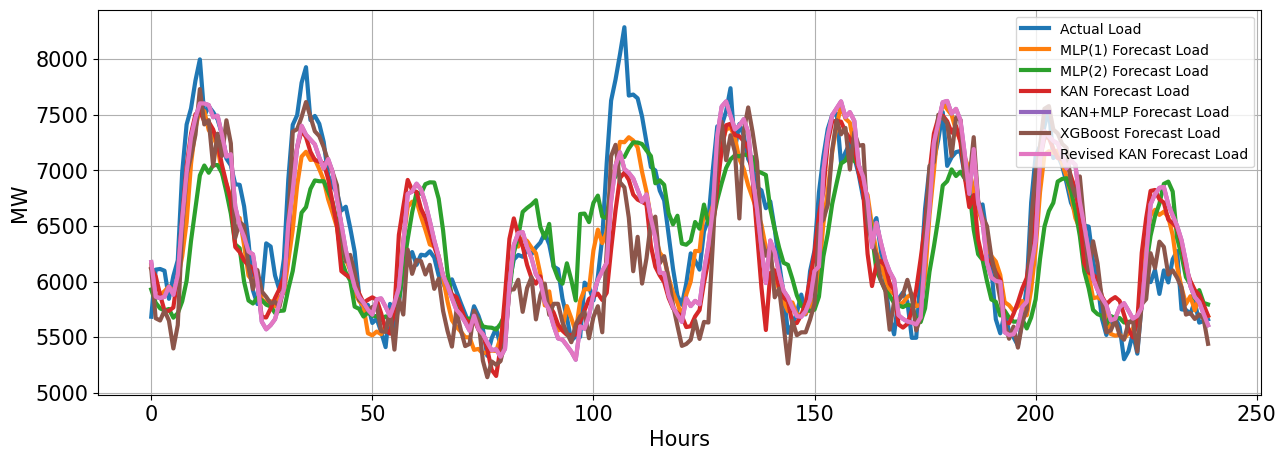

In [43]:
f = plt.figure(figsize=(15,5))
plt.plot(actual[:240],linewidth=3,label="Actual Load")
plt.plot(pre_ann_1_[:240],linewidth=3,label="MLP(1) Forecast Load")
plt.plot(pre_ann_2_[:240],linewidth=3,label="MLP(2) Forecast Load")
plt.plot(pre_KAN_[:240],linewidth=3,label="KAN Forecast Load")
plt.plot(pre_ann_3_[:240],linewidth=3,label="KAN+MLP Forecast Load")
plt.plot(XGBR_pre_[:240],linewidth=3,label="XGBoost Forecast Load")
plt.plot(pre_ann_4_[:240],linewidth=3,label="Revised KAN Forecast Load")
# plt.ylim(6500,8000)
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours",fontsize=15)
plt.ylabel("MW",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
f.savefig("./COMPARE_AUTUMN.svg",format="svg",dpi=300)